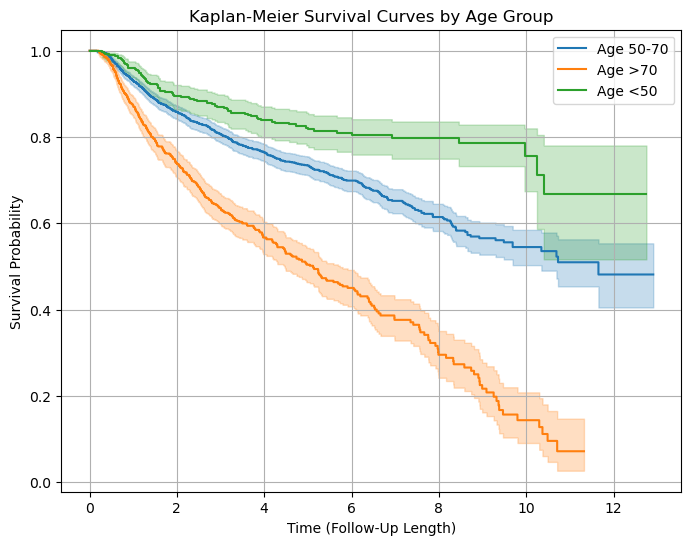

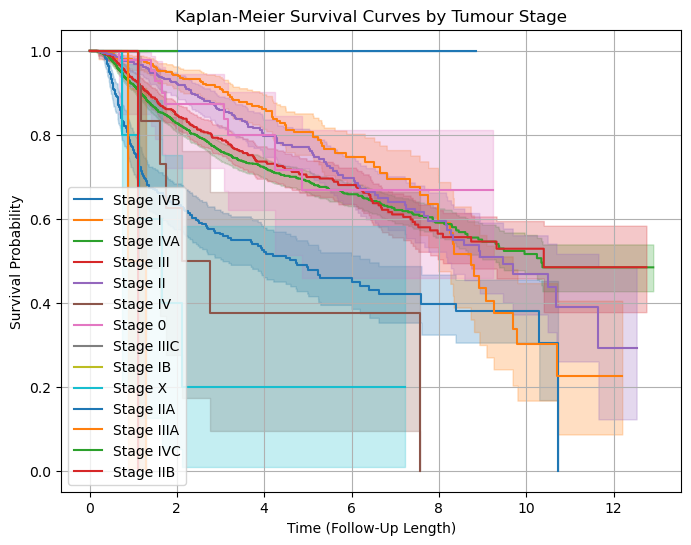

Log-rank test p-value for Age Groups:  1.6245180705927676e-36
Log-rank test p-value for Tumour Stages:  7.152923354938795e-07


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Load the dataset
file_path = "/Users/marwaissa/BINF-5507-RNA-1/Assignment 4/Data/RADCURE_Clinical_v04_20241219.xlsx"
xls = pd.ExcelFile(file_path)
clinical_df = pd.read_excel(xls, sheet_name="RADCURE_TCIA_Clinical_r2_offset")

# Create a copy of the original dataset to avoid modifying the original one
clinical_copy_df = clinical_df.copy()

# Convert 'Status' to binary event indicator
clinical_copy_df['Event'] = clinical_copy_df['Status'].map({'Alive': 0, 'Dead': 1})

# Okay let's define age groups now
clinical_copy_df['Age Group'] = pd.cut(clinical_copy_df['Age'], bins=[0, 50, 70, np.inf], labels=['<50', '50-70', '>70'])

# Drop missing values for the necessary columns :)
clinical_copy_df = clinical_copy_df.dropna(subset=['Length FU', 'Stage', 'Age Group'])
clinical_copy_df['Stage'] = clinical_copy_df['Stage'].astype(str)  # Ensure categorical

#Kaplan-Meier analysis
kmf = KaplanMeierFitter()

#Plot survival curves for age groups
plt.figure(figsize=(8, 6))
for age_group in clinical_copy_df['Age Group'].unique():
    age_data = clinical_copy_df[clinical_copy_df['Age Group'] == age_group]
    kmf.fit(age_data['Length FU'], event_observed=age_data['Event'], label=f"Age {age_group}")
    kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curves by Age Group')
plt.xlabel('Time (Follow-Up Length)')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid()
plt.show()

#Now Plot survival curves for tumour stages
plt.figure(figsize=(8, 6))
for stage in clinical_copy_df['Stage'].unique():
    stage_data = clinical_copy_df[clinical_copy_df['Stage'] == stage]
    kmf.fit(stage_data['Length FU'], event_observed=stage_data['Event'], label=f"Stage {stage}")
    kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curves by Tumour Stage')
plt.xlabel('Time (Follow-Up Length)')
plt.ylabel('Survival Probability')
plt.legend()
plt.grid()
plt.show()

# Log-rank test for age groups (<50 vs. >70)
age1 = clinical_copy_df[clinical_copy_df['Age Group'] == '<50']
age2 = clinical_copy_df[clinical_copy_df['Age Group'] == '>70']
log_rank_age = logrank_test(age1['Length FU'], age2['Length FU'], 
                            event_observed_A=age1['Event'], event_observed_B=age2['Event'])
print("Log-rank test p-value for Age Groups: ", log_rank_age.p_value)

# And finally log-rank test for tumour stages (Stage I vs. Stage IV)
stage1 = clinical_copy_df[clinical_copy_df['Stage'] == 'I']
stage4 = clinical_copy_df[clinical_copy_df['Stage'] == 'IV']
log_rank_stage = logrank_test(stage1['Length FU'], stage4['Length FU'], 
                              event_observed_A=stage1['Event'], event_observed_B=stage4['Event'])
print("Log-rank test p-value for Tumour Stages: ", log_rank_stage.p_value)


In [2]:
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt
import pandas as pd

# Make a copy of the original dataset
clinical_df_copy = clinical_df.copy()

# the three covariates
covariates = ['Age', 'Smoking PY', 'Dose']

# Convert covariates to numeric -> goign to force errors into NaN
for col in covariates:
    clinical_df_copy[col] = pd.to_numeric(clinical_df_copy[col], errors='coerce')

#Now Convert 'Status' to binary event indicator
clinical_df_copy['Event'] = clinical_df_copy['Status'].map({'Alive': 0, 'Dead': 1})

# Drop missing values for required columns
clinical_df_copy = clinical_df_copy.dropna(subset=['Length FU', 'Event'] + covariates)

#only keep relevant numeric columns
clinical_df_copy = clinical_df_copy[['Length FU', 'Event'] + covariates]

# Reset index to avoid issues with indexing (I was having problems w this :/)
clinical_df_copy = clinical_df_copy.reset_index(drop=True)

# Fit Cox Proportional Hazards Model
cox_model = CoxPHFitter()
cox_model.fit(clinical_df_copy, duration_col='Length FU', event_col='Event')

# Display model summary
cox_model.print_summary()

# Validate the Proportional Hazards Assumption
cox_model.check_assumptions(clinical_df_copy, p_value_threshold=0.05)


<lifelines.CoxPHFitter: fitted with 3287 total observations, 2249 right-censored observations>
             duration col = 'Length FU'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 3287
number of events observed = 1038
   partial log-likelihood = -7627.18
         time fit was run = 2025-03-15 01:11:54 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
Age         0.04      1.04      0.00            0.03            0.04                1.03                1.05
Smoking PY  0.01      1.01      0.00            0.01            0.01                1.01                1.02
Dose        0.01      1.01      0.01           -0.00            0.02                1.00                1.02

            cmp to     z      p  -log2(p)
covariate                                
Age           0.00 12.41 <0.005    115.00
Smoking PY    0.00 11.45 <0.005     98.48
Dose          0.00  1.81   0.07      3.84
---
Concordance = 0.66
Partial AIC = 15260.37
log-likelihood ratio test = 352.22 on 3 df
-log2(p) of ll-ratio test = 250.17

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3287 total observations, 2249 right-censored observations>
         test_name = proportional_hazard_test

---
                 test_statistic      p  -log2(p)
Age        km              9.77 <0.005      9.14
           rank            7.94 <0.005      7.69
Dose       km             10.05 <0.005      9.36
           rank            7.91 <0.005      7.67
Smoking PY km              0.23   0.63      0.66
           rank            0.34   0.56      0.83



1. Variable 'Age' failed the non-proportional test: p-value is 0.0018.

   Advice 1: the functional form of the variable 'Age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Age' using pd.cut, and then specify it in `strata=['Age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'Dose' failed the non-proportional test: p-value is 0.0015.

   Advice 1: the functional form of the variable 'Dose' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try bin

[]

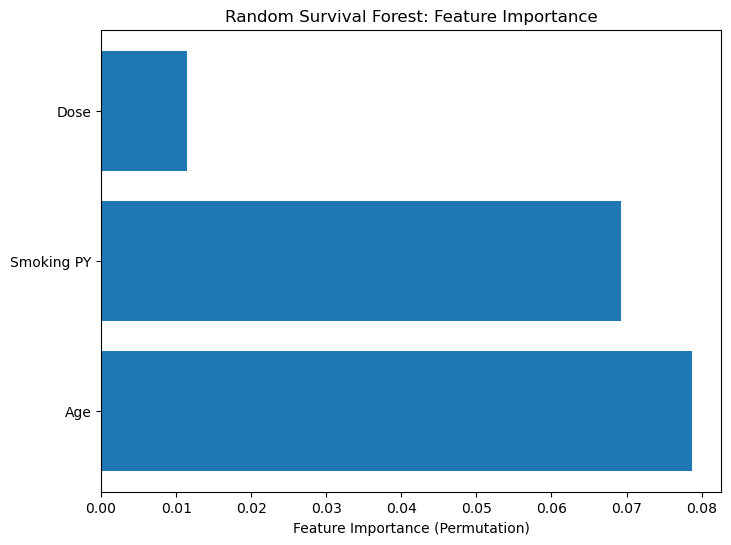

C-index for Random Survival Forest model: 0.6505770297367636


In [ ]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Prepare the dataset for RSF
# Event column needs to be boolean (True=1, False=0) for RSF
clinical_df_copy['Event'] = clinical_df_copy['Event'].astype(bool)

# Select covariates
covariates_rsf = ['Age', 'Smoking PY', 'Dose']

# ok now prepare the covariates and duration/event for RSF model
X = clinical_df_copy[covariates_rsf]
y = np.array(list(zip(clinical_df_copy['Event'], clinical_df_copy['Length FU'])), dtype=[('event', bool), ('duration', float)])

# Split the data into training and testing sets 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Random Survival Forest model
rsf_model = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rsf = rsf_model.predict(X_test)

# Calculate permutation feature importance
perm_importance = permutation_importance(rsf_model, X_test, y_test, n_repeats=10, random_state=42)

#Get feature importances and corresponding labels
feature_importances = perm_importance.importances_mean
features = X.columns

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.barh(features, feature_importances)
plt.xlabel("Feature Importance (Permutation)")
plt.title("Random Survival Forest: Feature Importance")
plt.show()

# Evaluate C-index for RSF model, yay!
c_index_rsf = concordance_index_censored(y_test['event'], y_test['duration'], y_pred_rsf)[0]
print(f"C-index for Random Survival Forest model: {c_index_rsf}")

In [8]:
# Get C-index for Cox Proportional Hazards model
c_index_cox = cox_model.score(clinical_df_copy, scoring_method="concordance_index")
print("C-index for Cox Proportional Hazards model: ", c_index_cox)

# Compare C-indices
print("C-index for RSF: ", c_index_rsf)
print("C-index for Cox regression: ", c_index_cox)


C-index for Cox Proportional Hazards model:  0.656330462448678
C-index for RSF:  0.6505770297367636
C-index for Cox regression:  0.656330462448678
